# Fitting a Model to Data

In [1]:
import numpy as np
import scipy.optimize as op
import emcee
import corner
import matplotlib.pyplot as pl
%matplotlib inline

In [43]:
# Step 1: write likelihood function (the probability of a dataset given the model parameters)


# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 100
x = np.sort(15*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

In [44]:
# Linear least squares solution

A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

In [45]:
# Likelihood (Gaussian) Function

def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [46]:
# Find numerical optimum of this likelihood function

nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

In [47]:
# Log prior (up to a constant)

def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [48]:
# Full log-probability function

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [49]:
# Sampling the Distrubution


# Start with initializing the walkers
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [50]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [51]:
# Run MCMC for 500 steps
sampler.run_mcmc(pos, 500)

(array([[-1.03630786,  4.57773431, -0.69518916],
        [-0.982873  ,  4.38193059, -0.60268915],
        [-0.94287152,  4.34391413, -0.65720057],
        [-0.97928162,  4.23384979, -0.63216964],
        [-0.95648441,  4.20615831, -0.5160289 ],
        [-1.03970494,  4.65520766, -0.74285939],
        [-0.98130838,  4.40299538, -0.74814701],
        [-0.94683851,  4.30464919, -0.47775846],
        [-1.06027384,  4.689759  , -0.60040209],
        [-0.97970733,  4.28458321, -0.51691471],
        [-0.98003893,  4.51909903, -0.7013782 ],
        [-1.03551886,  4.6484067 , -0.68444876],
        [-1.00725425,  4.70214868, -0.68439788],
        [-0.95295323,  4.16024286, -0.58609374],
        [-1.05764003,  4.78791277, -0.7180993 ],
        [-0.91626447,  4.08687854, -0.50688988],
        [-1.00192521,  4.48497483, -0.66015719],
        [-0.94530652,  4.16783039, -0.42037491],
        [-0.8941301 ,  4.07716769, -0.46071605],
        [-1.09205345,  4.91724652, -0.68853914],
        [-1.00144027

In [52]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

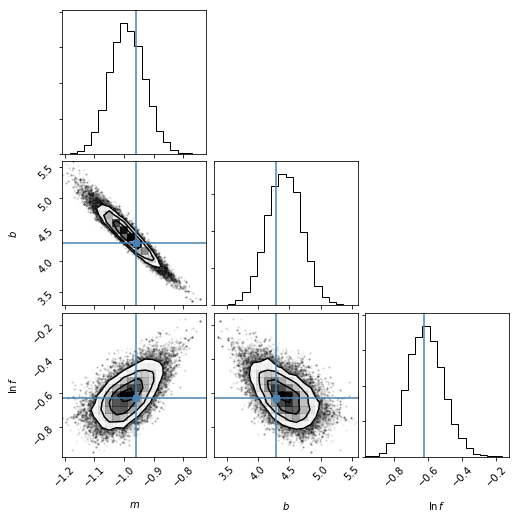

In [53]:
# Results

#error because corner is not installed
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
fig.savefig("triangle.png")

-0.981193056331
4.49476048401


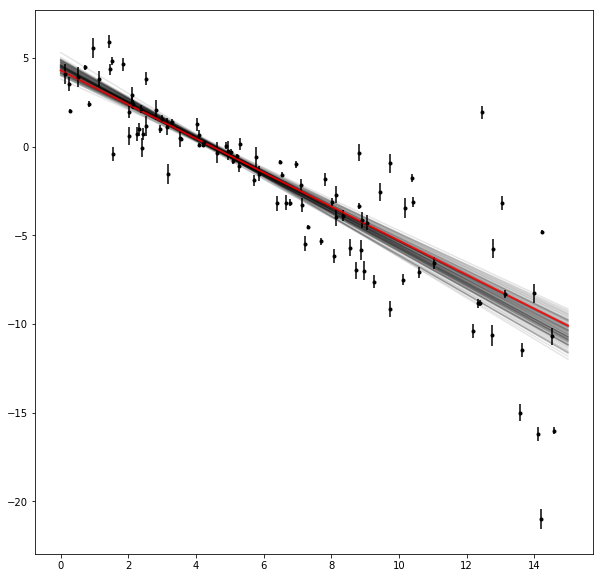

In [59]:
pl.figure(figsize=(10,10))
xl = np.array([0, 15])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.1)
pl.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
pl.errorbar(x, y, yerr=yerr, fmt=".k")
print(m)
print(b)

In [55]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))